In [182]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from sympy.printing.pytorch import torch

from tqdm import tqdm

## Spring-Mass-Damper System

### System dynamics

Consider the following spring-mass-damper system

<img src="../images/spring-mass-damper.png" width="250"/>

Let $\bar{x}$ be the rest position of the mass and define $y = x - \bar{x}$. The equation of motion in terms of $y$ is
$$m\ddot{y} + b\dot{y} + ky = 0.$$
Suppose that the initial conditions are $y(0) = y_0$ and $\dot{y}(0) = v_0$. This is a simple dynamical system and the solution is available as a closed-form expression.

### Exact solution

Suppose also that $b^2 < 4mk$. In this case, the system is underdamped and exhibits a natural oscillatory behaviour. The solution of the above initial value problem is
$$y(t) = e^{-\frac{b}{2m}t}\left(y_0 \cos(\omega t) + c\sin(\omega t)\right),$$
where
$$\omega = \frac{\sqrt{4mk - b^2}}{2m}, c = \frac{v_0 + \frac{by_0}{2m}}{\omega}.$$

In [183]:
def spring_solution(t, m_, b_, k_, y0_, v0_):
    a = b_ / (2 * m_)
    omg = np.sqrt(4*m_*k_ - b_**2) / (2*m_)
    c = (v0_ + a*y0_) / omg
    return torch.exp(-a*t) * (y0_ * torch.cos(omg * t) + c * torch.sin(omg * t))

## Neural Network

We will approximate the solution by a fully-connected neural network with linear layers and the sigmoid activation function.

<img src="../images/nn.png" width="300"/>

With this NN we seek to approximate the solution of the ODE. The input will be the time $t$ and the output will be an approximation $\hat{y}(t) \approx y(t)$.


In [184]:
class FullyConnectedNN(nn.Module):

    def __init__(self, hidden_layers):
        super().__init__()
        layers = []
        n_hidden_layers = len(hidden_layers)
        in_ = 1
        for i in range(n_hidden_layers):
            out_ = hidden_layers[i]
            layer_ = nn.Sequential(nn.Linear(in_, out_), nn.Sigmoid())
            in_ = out_
            layers.append(layer_)
        layers.append(nn.Linear(in_, 1))
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)


**Question:** What is the number of parameters of the network `FullyConnectedNN(hidden_layers=[32, 64])`?

## Data generation

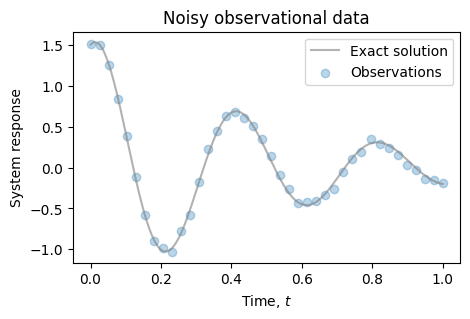

In [185]:
# first, create some noisy observational data
torch.manual_seed(123)

# Parameters
m = 1 # mass
b = 4 # damping coeff
k = 250 # spring constant
y0 = 1.5 # initial displacement
v0 = 5 # initial velocity

# Exact solution
t_test = torch.linspace(0, 1, 300).view(-1, 1)
u_exact = spring_solution(t_test, m, b, k, y0, v0)

# Noisy Observations
n_observations = 40
noise_level = 0.04
t_obs = torch.linspace(0,1,n_observations).view(-1,1)
u_obs = spring_solution(t_obs, m, b, k, y0, v0) + noise_level * torch.randn_like(t_obs)

plt.figure(figsize=(5,3))
plt.title("Noisy observational data")
plt.plot(t_test[:,0], u_exact[:,0], label="Exact solution", color="tab:grey", alpha=0.6)
plt.scatter(t_obs[:,0], u_obs[:,0], label="Observations", alpha=0.3)
plt.xlabel("Time, $t$")
plt.ylabel("System response")
plt.legend()
plt.show()

## Loss function

The loss function we will aim to minimise is
$$
\mathcal{L}(\theta, b)
{}={}
\underbracket{\frac{1}{N} \sum^{N}_{i} \left( \left[ m\frac{d^2}{dt^2} + b \frac{d}{dt} + k \right] \hat{y}(t_{i};\theta) \right)^2}_{\text{ODE loss}}
{}+{}
\lambda_1\underbracket{\frac{1}{M} \sum^{M}_{j} \left( \hat{y}(t_{j};\theta) - y_{\mathrm{obs}}(t_{j})\right)^2}_{\text{Obervation loss}}
$$

In [186]:
def lossfun(pinn_model, t_physics_, t_observations_, u_observations_, lambda_obs_, m_, b_, k_):
    # ODE loss
    u_t_physics = pinn_model(t_physics)
    dudt = torch.autograd.grad(u_t_physics, t_physics_, torch.ones_like(u_t_physics), create_graph=True)[0]
    d2udt2 = torch.autograd.grad(dudt, t_physics_, torch.ones_like(dudt), create_graph=True)[0]
    loss_ode = torch.mean((m_ * d2udt2 + b_ * dudt + k_ * u_t_physics)**2)
    # Observations loss
    u_obs_ = pinn(t_observations_)
    loss_observations = torch.mean((u_obs_ - u_observations_)**2)
    return loss_ode + lambda_obs_ * loss_observations, loss_ode, loss_observations

## Model training

In [ ]:
torch.manual_seed(123)
pinn = FullyConnectedNN([32, 64, 128, 64, 32])
t_physics = torch.linspace(0, 1, 50).view(-1,1).requires_grad_(True)
lam = 1.5e4
n_epochs = 35000

# treat mu as a learnable parameter
b_param = nn.Parameter(torch.zeros(1, requires_grad=True))
b_cache, loss_cache = torch.zeros(n_epochs), torch.zeros((n_epochs, 3))

# add mu to the optimiser
optimiser = torch.optim.Adam( list(pinn.parameters()) + [b_param], lr=0.0002)
for i in tqdm(range(n_epochs), desc="Training PINN"):
    loss, loss_ode, loss_obs = lossfun(pinn, t_physics, t_obs, u_obs, lam, m, b_param, k)
    optimiser.zero_grad()
    loss.backward()
    optimiser.step()
    b_cache[i] = b_param.item(); loss_cache[i, :] = torch.tensor([ loss.item(), loss_ode.item(), loss_obs.item()])

Training PINN:  78%|███████▊  | 27409/35000 [00:29<00:08, 925.81it/s]

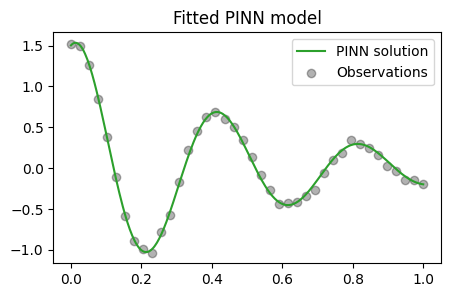

In [175]:
u = pinn(t_test).detach()
plt.figure(figsize=(5, 3))
plt.plot(t_test[:,0], u[:,0], label="PINN solution", color="tab:green")
plt.scatter(t_obs[:,0], u_obs[:,0], color='black', label="Observations", alpha=0.3)
plt.title("Fitted PINN model")
plt.legend()
plt.show()

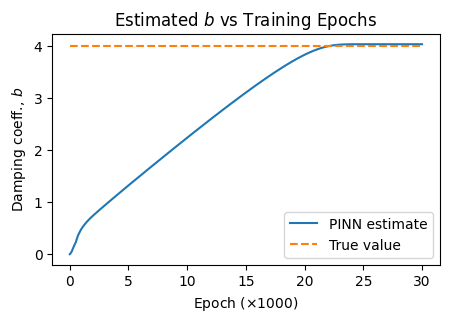

In [176]:
plt.figure(figsize=(5, 3))
plt.title("Estimated $b$ vs Training Epochs")
plt.plot(np.arange(n_epochs)/1000, b_cache, label="PINN estimate")
plt.plot([0, n_epochs/1000], [b, b], '--', label="True value")
plt.legend()
plt.xlabel("Epoch ($\\times 1000$)"); plt.ylabel("Damping coeff., $b$")
plt.show()

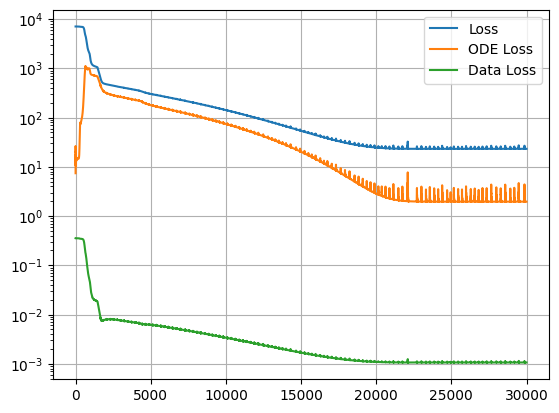

In [181]:
plt.figure(figsize=(5, 3))
plt.semilogy(loss_cache, label=["Loss", "ODE Loss", "Data Loss"])
plt.legend()
plt.grid()
plt.show()